In [1]:
import gc
import sys
import pickle
import random

import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
from easydict import EasyDict as edict
from sklearn.metrics import roc_auc_score
from catboost import Pool, CatBoostClassifier

sys.path.append('../src')
from factory import get_fold
from utils import seed_everything, DataHandler, reduce_mem_usage
from make_features.feature_utils import TargetEncoding

In [2]:
version_name = 'model_20201217_catboost_v2'
ver_dir = Path(f'./{version_name}')

ver_dir.mkdir(exist_ok=True)

train_pickle = '../folds/cv1_train.pickle'
valid_pickle = '../folds/cv1_valid.pickle'
question_file = '../data/input/questions.csv'
lecture_file = '../data/input/lectures.csv'


te_cfg = edict({
    'name': 'KFold',
    'params': {
        'n_splits': 5,
        'shuffle': True,
        'random_state': 0,
    },
    'split': {
        'y': 'user_id',
        'groups': None
    },
    'weight': 'average'
})

s = 1e-3

debug = False

dh = DataHandler()
seed_everything(2020)

In [3]:
def add_loop_feats(df, answered_correctly_sum_user_dict, attempt_content_dict, count_user_dict,
                   timestamp_diff3_dict, seq2dec_w7_dict, task_user_dict):

    answered_correctly_sum_user_array = np.zeros(len(df), dtype=np.int32)
    attempt_content_array = np.zeros(len(df), dtype=np.int32)
    count_user_array = np.zeros(len(df), dtype=np.int32)
    timestamp_diff1_array = np.zeros(len(df), dtype=np.int32)
    timestamp_diff2_array = np.zeros(len(df), dtype=np.int32)
    timestamp_diff3_array = np.zeros(len(df), dtype=np.int32)
    seq2dec_w7_array = np.zeros(len(df), dtype=np.float32)

    default_attempt_content_array = np.zeros(13523, dtype=np.int8)
#     default_timestamp_diff3_array = np.zeros(3, dtype=np.int64)
#     default_seq2dec_w7_array = np.zeros(7, dtype=bool)

    for idx, row in enumerate(tqdm(df[['user_id', 'content_id', 'timestamp', 'answered_correctly', 'task_container_id']].values)):
        user_id = row[0]
        content_id = row[1]
        timestamp = row[2]
        target = row[3]
        task_container_id = row[4]

        # insert values
        answered_correctly_sum_user_array[idx] = answered_correctly_sum_user_dict.setdefault(user_id, 0)
        attempt_content_array[idx] = attempt_content_dict.setdefault(user_id, default_attempt_content_array.copy())[content_id]
        count_user_array[idx] = count_user_dict.setdefault(user_id, 0)

#         timestamp_diff1_array[idx] = timestamp - timestamp_diff3_dict.setdefault(user_id, default_timestamp_diff3_array.copy())[-1]
#         timestamp_diff2_array[idx] = timestamp - timestamp_diff3_dict.setdefault(user_id, default_timestamp_diff3_array.copy())[-2]
#         timestamp_diff3_array[idx] = timestamp - timestamp_diff3_dict.setdefault(user_id, default_timestamp_diff3_array.copy())[-3]

#         seq2dec_feats = seq2dec_w7_dict.setdefault(user_id, default_seq2dec_w7_array.copy())

#         for i, f in enumerate(seq2dec_feats[::-1]):
#                 seq2dec_w7_array[idx] += f * 10 ** -i

        # update values
        if task_user_dict.setdefault(user_id, -1) != task_container_id:
            answered_correctly_sum_user_dict[user_id] += target
            attempt_content_dict[user_id][content_id] += 1
            count_user_dict[user_id] += 1
            task_user_dict[user_id] = task_container_id

#         new_timestamp_diff3_array = timestamp_diff3_dict[user_id]
#         new_timestamp_diff3_array[0] = new_timestamp_diff3_array[1]
#         new_timestamp_diff3_array[1] = new_timestamp_diff3_array[2]
#         new_timestamp_diff3_array[2] = timestamp
#         timestamp_diff3_dict[user_id] = new_timestamp_diff3_array

#         new_seq2dec_w7_array = seq2dec_w7_dict[user_id]
#         new_seq2dec_w7_array[0] = new_seq2dec_w7_array[1]
#         new_seq2dec_w7_array[1] = new_seq2dec_w7_array[2]
#         new_seq2dec_w7_array[2] = new_seq2dec_w7_array[3]
#         new_seq2dec_w7_array[3] = new_seq2dec_w7_array[4]
#         new_seq2dec_w7_array[4] = new_seq2dec_w7_array[5]
#         new_seq2dec_w7_array[5] = new_seq2dec_w7_array[6]
#         new_seq2dec_w7_array[6] = (target == 1)
#         seq2dec_w7_dict[user_id] = new_seq2dec_w7_array
    
    drop_cols = [
        'row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id', 'user_answer',
        'max_time_stamp', 'rand_time_stamp', 'viretual_time_stamp'
    ]
    df = df.drop(drop_cols, axis=1)
    _ = gc.collect()
    
    user_feats_df = pd.DataFrame({
        'answered_correctly_sum_user': answered_correctly_sum_user_array,
        'count_user': count_user_array,
        'answered_correctly_avg_user': answered_correctly_sum_user_array / (count_user_array + s),
        'attempt_content': attempt_content_array,
    })
    
    user_feats_df = reduce_mem_usage(user_feats_df)
    df = reduce_mem_usage(df)
    
    df = pd.concat([df, user_feats_df], axis=1)

#     df['answered_correctly_sum_user'] = answered_correctly_sum_user_array
#     df['count_user'] = count_user_array
#     df['answered_correctly_avg_user'] = answered_correctly_sum_user_array / (count_user_array + s)
#     df['attempt_content'] = attempt_content_array
#     df['timestamp_diff1'] = timestamp_diff1_array
#     df['timestamp_diff2'] = timestamp_diff2_array
#     df['timestamp_diff3'] = timestamp_diff3_array
#     df['seq2dec_w7'] = seq2dec_w7_array

#     for i in range(7):
#         count_user_idx = df[df['count_user'] <= i].index

#         if i == 0:
#             df.loc[count_user_idx, f'timestamp_diff1'] = np.nan
#         elif i == 1:
#             df.loc[count_user_idx, f'timestamp_diff2'] = np.nan
#         elif i == 2:
#             df.loc[count_user_idx, f'timestamp_diff3'] = np.nan
#         elif i == 6:
#             df.loc[count_user_idx, f'seq2dec_w7'] = np.nan

    return df


def save_pickle(obj, f_name):
    with open(f_name, 'wb') as f:
        pickle.dump(obj, f)

## Load Data

In [4]:
train = pd.read_pickle(train_pickle)
valid = pd.read_pickle(valid_pickle)

if debug:
    train = train[:1_000_000]
    valid = valid[:10_000]
    
train = train.loc[train.content_type_id == False].reset_index(drop=True)
valid = valid.loc[valid.content_type_id == False].reset_index(drop=True)

## Merge Data

In [5]:
# w2v
tag_w2v_max_encoder = dh.load('../data/processed/tag_w2v_max_encoder.pkl')
tag_w2v_mean_encoder = dh.load('../data/processed/tag_w2v_mean_encoder.pkl')
tag_w2v_median_encoder = dh.load('../data/processed/tag_w2v_median_encoder.pkl')
tag_w2v_min_encoder = dh.load('../data/processed/tag_w2v_min_encoder.pkl')

content_w2v_df = pd.DataFrame.from_dict(tag_w2v_max_encoder, orient='index').reset_index()
content_w2v_df.columns = ['content_id', 'tag_w2v_max']
content_w2v_df['tag_w2v_mean'] = content_w2v_df['content_id'].map(tag_w2v_mean_encoder)
content_w2v_df['tag_w2v_median'] = content_w2v_df['content_id'].map(tag_w2v_median_encoder)
content_w2v_df['tag_w2v_min'] = content_w2v_df['content_id'].map(tag_w2v_min_encoder)

for col in content_w2v_df.columns[1:]:
    encoder = dict(content_w2v_df[['content_id', col]].values)
    train[col] = train['content_id'].map(encoder)
    valid[col] = train['content_id'].map(encoder)
    
    
# tsne
content_id_tsne_0_encoder = dh.load('../data/processed/tsne_encoder_0.pkl')
content_id_tsne_1_encoder = dh.load('../data/processed/tsne_encoder_1.pkl')

content_tsne_df = pd.DataFrame.from_dict(content_id_tsne_0_encoder, orient='index').reset_index()
content_tsne_df.columns = ['content_id', 'content_id_tsne_0']
content_tsne_df['content_id_tsne_1'] = content_tsne_df['content_id'].map(content_id_tsne_1_encoder)

for col in content_tsne_df.columns[1:]:
    encoder = dict(content_tsne_df[['content_id', col]].values)
    train[col] = train['content_id'].map(encoder)
    valid[col] = train['content_id'].map(encoder)
    
    
# agg
agg_prior_question_elapsed_time_df = pd.read_csv('../data/processed/agg_prior_question_elapsed_time_by_content_id_df.csv')

for col in agg_prior_question_elapsed_time_df.columns[1:]:
    encoder = dict(agg_prior_question_elapsed_time_df[['content_id', col]].values)
    train[col] = train['content_id'].map(encoder)
    valid[col] = train['content_id'].map(encoder) 


# user_lag
user_lag_median_encoder = dh.load('../data/processed/user_lag_median_encoder.pkl')

user_lag_median_df = pd.DataFrame.from_dict(user_lag_median_encoder, orient='index').reset_index()
user_lag_median_df.columns = ['user_id', 'timestamp_lag_median']

for col in user_lag_median_df.columns[1:]:
    encoder = dict(user_lag_median_df[['user_id', col]].values)
    train[col] = train['user_id'].map(encoder)
    valid[col] = train['user_id'].map(encoder)
    
    
# Target Encoding
te_content_id_encoder = dh.load('../data/processed/te_content_id_by_answered_correctly.pkl')
te_content_id_and_attempt_encoder = dh.load('../data/processed/te_content_id_and_attempt_c_by_answered_correctly.pkl')

target_encoding_df1 = pd.read_feather('../features/te_content_id_by_answered_correctly_train.feather')
target_encoding_df2 = pd.read_feather('../features/te_content_id_and_attempt_c_by_answered_correctly_train.feather')

target_encoding_df = pd.concat([target_encoding_df1, target_encoding_df2], axis=1)

train_row_id = train['row_id'].values
valid_row_id = valid['row_id'].values

for col in target_encoding_df.columns:
    train[col] = target_encoding_df.loc[train_row_id, col].values
    valid[col] = target_encoding_df.loc[valid_row_id, col].values
    
del target_encoding_df1, target_encoding_df2, target_encoding_df; gc.collect()


# part
questions_df = pd.read_csv(question_file)
encoder = dict(questions_df[['question_id', 'part']].values)
train['part'] = train['content_id'].map(encoder)
valid['part'] = valid['content_id'].map(encoder)

In [6]:
answered_correctly_sum_user_dict = {}
attempt_content_dict = {}
count_user_dict = {}
timestamp_diff3_dict = {}
seq2dec_w7_dict = {}
task_user_dict = {}

train = add_loop_feats(train, answered_correctly_sum_user_dict, attempt_content_dict,
                                  count_user_dict, timestamp_diff3_dict, seq2dec_w7_dict, task_user_dict)
valid = add_loop_feats(valid, answered_correctly_sum_user_dict, attempt_content_dict,
                                  count_user_dict, timestamp_diff3_dict, seq2dec_w7_dict, task_user_dict)

# train = reduce_mem_usage(train)
# valid = reduce_mem_usage(valid)

In [7]:
if debug:
    save_pickle(answered_correctly_sum_user_dict, ver_dir / 'debug_answered_correctly_sum_user_dict.pkl')
    save_pickle(attempt_content_dict, ver_dir / 'debug_attempt_content_dict.pkl')
    save_pickle(count_user_dict, ver_dir / 'debug_count_user_dict.pkl')
#     save_pickle(timestamp_diff3_dict, ver_dir / 'debug_timestamp_diff3_dict.pkl')
#     save_pickle(seq2dec_w7_dict, ver_dir / 'debug_seq2dec_w7_dict.pkl')
    save_pickle(task_user_dict, ver_dir / 'debug_task_user_dict.pkl')
    train.to_pickle(ver_dir / 'debug_train_features_df.pkl')
    valid.to_pickle(ver_dir / 'debug_valid_features_df.pkl')
else:
    save_pickle(answered_correctly_sum_user_dict, ver_dir / 'answered_correctly_sum_user_dict.pkl')
    save_pickle(attempt_content_dict, ver_dir / 'attempt_content_dict.pkl')
    save_pickle(count_user_dict, ver_dir / 'count_user_dict.pkl')
#     save_pickle(timestamp_diff3_dict, ver_dir / 'timestamp_diff3_dict.pkl')
#     save_pickle(seq2dec_w7_dict, ver_dir / 'seq2dec_w7_dict.pkl')
    save_pickle(task_user_dict, ver_dir / 'task_user_dict.pkl')
    train.to_pickle(ver_dir / 'train_features_df.pkl')
    valid.to_pickle(ver_dir / 'valid_features_df.pkl')

In [8]:
TARGET = 'answered_correctly'
FEATS = [
    'part', 'prior_question_elapsed_time', 'task_container_id',
    'te_content_id_by_answered_correctly', 'te_content_id_and_attempt_c_by_answered_correctly',
    'tag_w2v_max', 'tag_w2v_mean', 'tag_w2v_median', 'tag_w2v_min',
    'content_id_tsne_0', 'content_id_tsne_1',
    'prior_question_elapsed_time_mean', 'prior_question_elapsed_time_median', 'prior_question_elapsed_time_std',
    'timestamp_lag_median',
    'answered_correctly_avg_user', 'answered_correctly_sum_user', 'attempt_content', 'count_user',
#     'timestamp_diff1', 'timestamp_diff2', 'timestamp_diff3', 'seq2dec_w7',
]

dro_cols = list(set(train.columns) - set(FEATS))
y_tr = train[TARGET]
y_va = valid[TARGET]
train.drop(dro_cols, axis=1, inplace=True)
valid.drop(dro_cols, axis=1, inplace=True)
_=gc.collect()

In [9]:
cat_train = Pool(train[FEATS], label=y_tr)
cat_valid = Pool(valid[FEATS], label=y_va)

if not debug:
    del train, y_tr
    _=gc.collect()

In [10]:
cat_params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'learning_rate': 0.1,
    'iterations': 30_000,
    'depth': 8,
    'l2_leaf_reg': 3.0,
    'bagging_temperature': 0.2,
    'border_count': 128,
    'od_type': 'Iter',
    'metric_period': 50,
    'od_wait': 50,
    'random_seed': 2020,
    'task_type': 'GPU'
}

cb = CatBoostClassifier(**cat_params)
model = cb.fit(cat_train,
                      eval_set=cat_valid,
                      use_best_model=True,
                      verbose_eval=100,
                      early_stopping_rounds=100,
                      plot=False)

print('\nauc:', roc_auc_score(y_va, model.predict_proba(valid[FEATS])[:, 1]))

0:	learn: 0.7395106	test: 0.7443124	best: 0.7443124 (0)	total: 566ms	remaining: 4h 42m 47s
100:	learn: 0.7552298	test: 0.7547017	best: 0.7555613 (44)	total: 30s	remaining: 2h 27m 53s
bestTest = 0.7555612624
bestIteration = 44
Shrink model to first 45 iterations.

auc: 0.7555613101172941


<AxesSubplot:xlabel='importance', ylabel='feature'>

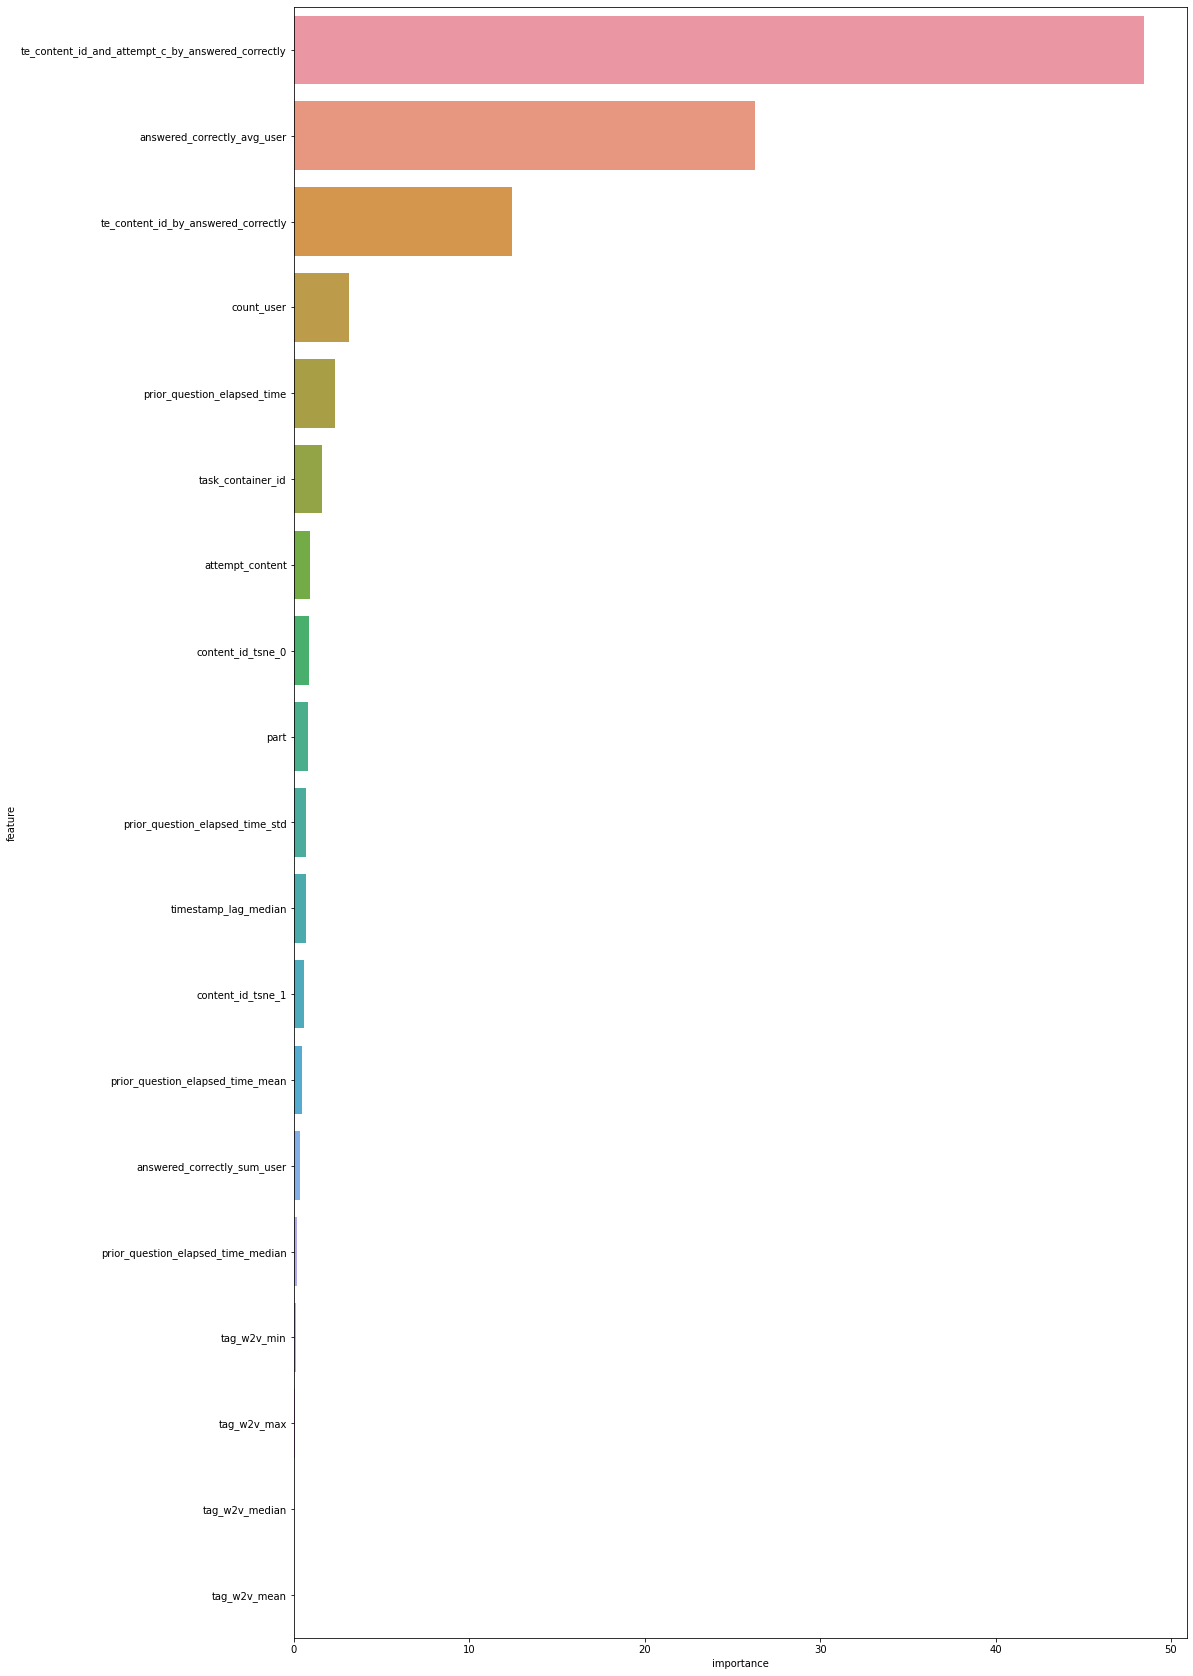

In [11]:
imp_df = pd.DataFrame({'feature': FEATS, 'importance': model.feature_importances_})

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 30))
sns.barplot(x='importance', y='feature', data=imp_df.sort_values(by='importance', ascending=False))

In [12]:
if debug:
    save_pickle(model, ver_dir / f'debug_{version_name}.pkl')
    save_pickle(te_content_id_encoder, ver_dir / 'debug_te_content_id_encoder.pkl')
    save_pickle(ver_dir, ver_dir / 'debug_te_content_id_and_attempt_encoder.pkl')

    content_w2v_df.to_csv(ver_dir / 'debug_content_w2v_df.csv', index=False)
    content_tsne_df.to_csv(ver_dir / 'debug_content_tsne_df.csv', index=False)
    agg_prior_question_elapsed_time_df.to_csv(ver_dir / 'debug_agg_prior_question_elapsed_time_df.csv', index=False)
    user_lag_median_df.to_csv(ver_dir / 'debug_user_lag_median_df.csv', index=False)
else:
    save_pickle(model, ver_dir / f'{version_name}.pkl')
    save_pickle(te_content_id_encoder, ver_dir / 'te_content_id_encoder.pkl')
    save_pickle(ver_dir, ver_dir / 'te_content_id_and_attempt_encoder.pkl')

    content_w2v_df.to_csv(ver_dir / 'content_w2v_df.csv', index=False)
    content_tsne_df.to_csv(ver_dir / 'content_tsne_df.csv', index=False)
    agg_prior_question_elapsed_time_df.to_csv(ver_dir / 'agg_prior_question_elapsed_time_df.csv', index=False)
    user_lag_median_df.to_csv(ver_dir / 'user_lag_median_df.csv', index=False)